# Read UOP mooring data and analyze isothermal displacements


The goal is to examine intermittency of internal waves.  The inital plan is to:
- Load WHOI Upper Ocean Processes Group mooring data
- Compute isothermal displacement at some depth in the permanent thermocline
- Using Stratus mooring data to start

Started 11/23/2021

@jtomfarrar


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
# import datetime
import gsw

################
# This allows us to import Tom_tools
import sys
sys.path.append('../Tom_tools/') # you may need to adjust this path
# sys.path.append('../SWOT_IW_SSH/jtf/Tom_tools/') # you may need to adjust this path
import Tom_tools_v1 as tt
################


In [2]:
%matplotlib inline
# %matplotlib qt5

plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['savefig.dpi'] = 500
plt.close('all')

__figdir__ = "./plots/"
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

In [3]:
# plt.rcParams

Here is the data directory for WHOI Ocean Reference Station Moorings:
https://dods.ndbc.noaa.gov/thredds/catalog/oceansites/DATA/Stratus/catalog.html


Here is the data directory for SPURS-1:
https://podaac-opendap.jpl.nasa.gov/opendap/allData/insitu/L2/spurs1/mooring/SPURS_WHOI_1_D_TS.nc

Here is more information on SPURS-1 (e.g., mooring diagram):
http://uop.whoi.edu/projects/SPURS/spursdetails.html

In [4]:
if False: #make this statement true to use Stratus
    base_url = 'https://dods.ndbc.noaa.gov/thredds/dodsC/oceansites/DATA/Stratus/'
    filename = 'OS_Stratus_2008_D_TS.nc'
    url = base_url+filename
    plt_name='Stratus'
else:
    url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/insitu/L2/spurs1/mooring/SPURS_WHOI_1_D_TS.nc'#
#    url = 'SPURS_WHOI_1_D_TS.nc'
    plt_name='SPURS'

print(url)

https://podaac-opendap.jpl.nasa.gov/opendap/allData/insitu/L2/spurs1/mooring/SPURS_WHOI_1_D_TS.nc


In [5]:
ds = xr.open_dataset(url)

In [6]:
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 37, LATITUDE: 1, LONGITUDE: 1, TIME: 109617)
Coordinates:
  * TIME        (TIME) datetime64[ns] 2012-09-14T20:00:00.000003328 ... 2013-...
  * DEPTH       (DEPTH) float64 1.3 2.1 3.0 4.4 5.2 ... 200.5 300.0 350.0 400.0
  * LATITUDE    (LATITUDE) float64 24.58
  * LONGITUDE   (LONGITUDE) float64 -38.0
Data variables:
    INST        int32 ...
    INST_MFGR   (DEPTH) |S64 ...
    INST_MODEL  (DEPTH) |S64 ...
    INST_URL    (DEPTH) |S64 ...
    TEMP        (TIME, DEPTH) float64 ...
    CNDC        (TIME, DEPTH) float64 ...
    PSAL        (TIME, DEPTH) float64 ...
    INST_SN     (DEPTH) int32 ...
Attributes:
    data_type:                       OceanSites time-series data
    Conventions:                     CF 1.6, OceanSITES-1.3, ACDD 1.2
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    netcdf_version:                  3.5
    format_version:                  1.3
    institution:                     WHOI
    source:                          moored surface buoy
    naming_authority:                OceanSITES
    cdm_data_type:                   timeSeriesProfile
    data_assembly_center:            WHOI-UOP
    qc_manual:                       OceanSITES Users Manual v1.2
    distribution_statement:           Follows CLIVAR (Climate Varibility and ...
    license:                          Follows CLIVAR (Climate Varibility and ...
    institution_references:          http://uop.whoi.edu
    keywords_vocabulary:             GCMD Science Keywords
    keywords:                        EARTH SCIENCE > Oceans > Salinity/Densit...
    keywords_vocabulary_URL:         http://gcmd.nasa.gov/Resources/valids/ar...
    standard_name_vocabulary:        CF-1.6
    site_code:                       SPURS
    title:                           Ocean salinity data from surface mooring...
    project:                         SPURS
    platform_code:                   SPURS
    wmo_platform_code:               
    deployment_number:               1
    deployment_code:                 2012
    id:                              SPURS_1_D_TS
    summary:                         Delayed mode salinity data from the WHOI...
    references:                      http://uop.whoi.edu/projects/spurs, http...
    citation:                        Data from the SPURS Surface Mooring were...
    acknowledgment:                  Support for this research was provided b...
    creator_name:                    J Tom Farrar
    creator_url:                     http://www.whoi.edu/profile/jfarrar/
    creator_email:                   Nan Galbraith
    pi_name:                         J Tom Farrar
    principal_investigator:          J Tom Farrar
    author:                          Nan Galbraith
    contact:                         Nan Galbraith
    publisher_name:                  Nan Galbraith
    publisher_url:                   http://www.whoi.edu/profile/ngalbraith
    publisher_email:                 Nan Galbraith
    contributor_name:                Kelan Huang, Nan Galbraith
    contributor_role:                Quality control and editing, Preliminary...
    date_created:                    2014-07-28T14:41:09Z
    date_modified:                   2014-07-28T14:41:09Z
    date_issued:                     2014-07-28T14:33:46Z
    date_update:                     2014-07-28T14:41:09Z
    update_interval:                 void
    history:                         Nov-Dec 2013, NGalbraith,JTFarrar, conve...
    comment:                         Combined data from instruments on surfac...
    data_mode:                       D
    Metadata_Link:                   http://uop.whoi.edu/projects/SPURS/SPURS...
    quality_index:                   excellent
    quality_control_procedure:       Data manually reviewed, clock drift corr...
    QC_manual:                       http://www.oceansites.org/data/quality_c...
    processing_level:                Drift corrections, post-calibrations, de...
    area:   

In [7]:
T = ds.TEMP.values

Text(0, 0.5, 'Depth [m]')

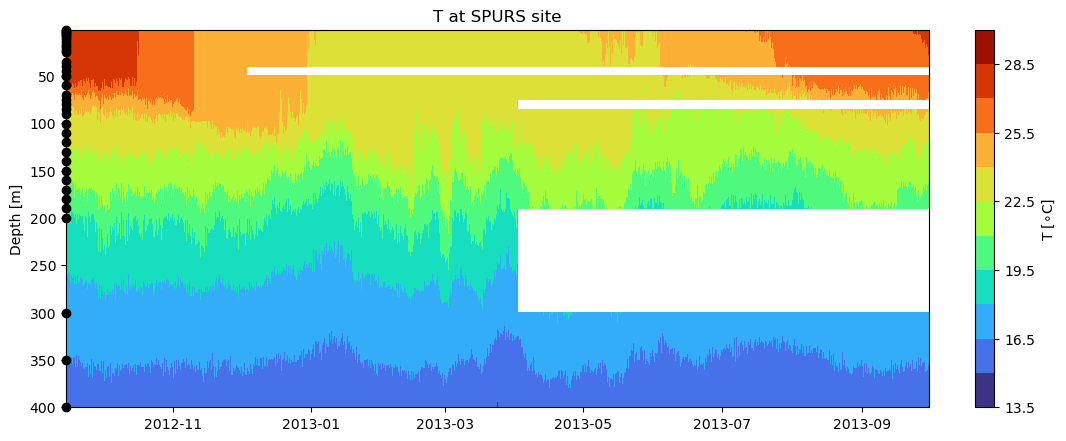

In [8]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
cs = plt.contourf(ds.TIME, ds.DEPTH, T.transpose(),10, cmap=plt.cm.turbo)
ax.invert_yaxis()
for z in ds.DEPTH:
    plt.plot(ds.TIME[0], z, 'ko', clip_on=False)
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('T [$\circ$C]',fontsize = 10)
    
plt.title('T at '+plt_name+' site')
# plt.title('T at Stratus site')
plt.ylabel('Depth [m]')

In [9]:
# Find the depth index near some target depth:
target_depth = 180
# target_depth = 150
# target_depth = 120
zind = np.flatnonzero(ds['DEPTH'].values-target_depth == np.min(np.abs(ds['DEPTH'].values-target_depth)))[0]

In [10]:
zind

31

In [11]:
ds['DEPTH'][zind].values

array(180.)

Text(0, 0.5, 'T [$^\\circ$C]')

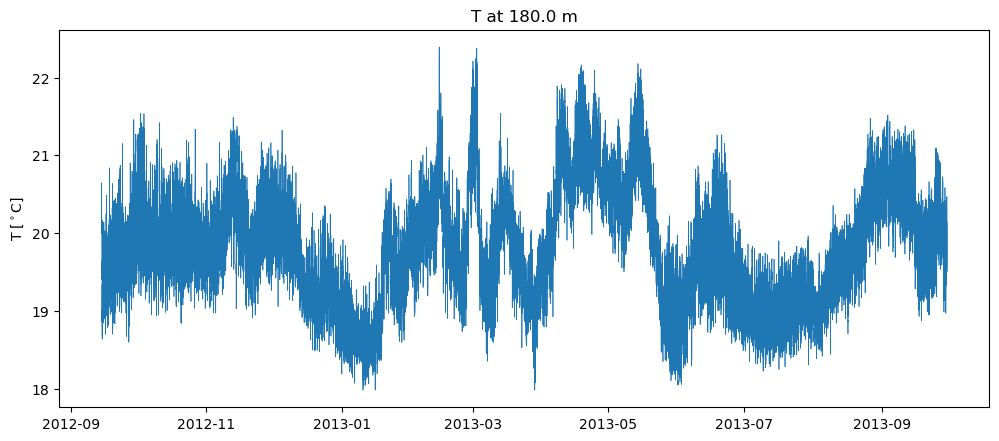

In [12]:
#
# Plotting
#
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
#plt.plot(time,vel_e[N//2:-N//2+1],label='IMU vel.')
plt.plot(ds['TIME'],ds['TEMP'][:,zind])
#plt.xlim(datetime.datetime(2019,4,25,12,43,0),datetime.datetime(2019,4,25,12,44,0))
#plt.ylim(-0.6,1.2)
#plt.xlabel('April 25, 2019')
plt.title('T at '+str(ds['DEPTH'][zind].values) + ' m')
plt.ylabel('T [$^\circ$C]')
# plt.savefig(__figdir__+'rain.pdf',**savefig_args)

## Now compute $\zeta$


Use $\zeta = \frac{T^\prime}{ \partial \bar{T} / \partial z}$

where the bar is a 10-day average

In [13]:
dT = ds['TEMP'][:,zind-1]-ds['TEMP'][:,zind+1]
dz = -(ds['DEPTH'][zind-1]-ds['DEPTH'][zind+1])
dT_dz = dT/dz.values

In [14]:
np.shape(dT_dz)

(109617,)

In [15]:
dt = np.diff(ds['TIME'])
dt.astype('timedelta64[s]')

array([300, 300, 299, ..., 299, 300, 300], dtype='timedelta64[s]')

In [16]:
dTbar_dz = tt.run_avg1d(dT_dz.values, 12*24*10)

In [17]:
Tprime = ds['TEMP'][:,zind] - tt.run_avg1d(ds['TEMP'][:,zind], 12*24*10)

In [18]:
zeta = Tprime/dTbar_dz

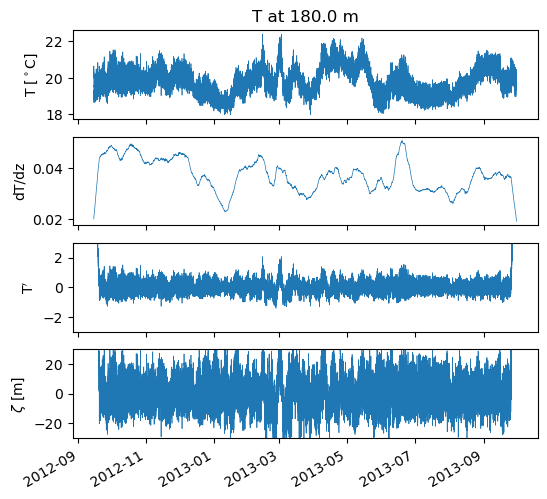

In [19]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(411)
plt.plot(ds['TIME'],ds['TEMP'][:,zind])
plt.title('T at '+str(ds['DEPTH'][zind].values) + ' m')
plt.ylabel('T [$^\circ$C]')

ax2 = fig.add_subplot(412)
plt.plot(ds['TIME'],dTbar_dz)
plt.ylabel('dT/dz')

ax3 = fig.add_subplot(413)
plt.plot(ds['TIME'],Tprime)
plt.ylabel('T$^\prime$')
plt.ylim([-3, 3])

ax4 = fig.add_subplot(414)
plt.plot(ds['TIME'],zeta)
plt.ylabel('$\zeta$ [m]')
plt.ylim([-30, 30])


fig.autofmt_xdate()

In [20]:
f = gsw.geostrophy.f(np.abs(ds.LATITUDE.values[0]))
inertial_period = 2*np.pi/f/3600
print('Latitude is '+ f'{ds.LATITUDE.values[0]:.1f}')
print('Inertial period is '+ f'{inertial_period:.1f}' + ' hours')
f_cpd=f*3600*24/(2*np.pi)
M2_cpd=24/12.42

Latitude is 24.6
Inertial period is 28.8 hours


Text(1.932367149758454, 0.01, '  M2')

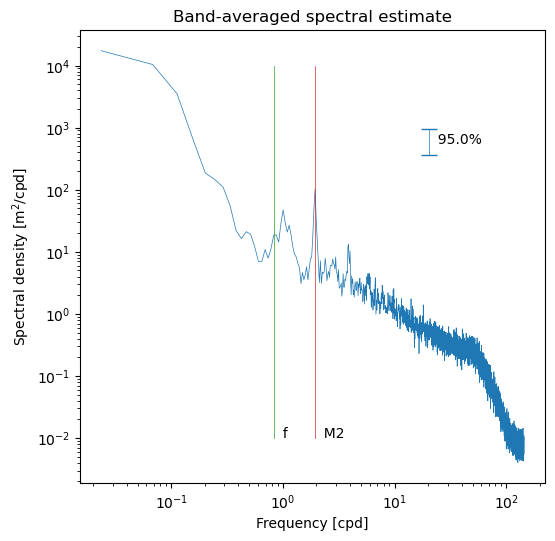

In [21]:
# use tt.spectrum_band_avg(yy,dt,M,winstr=None,plotflag=None,ebarflag=None)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
M = 17
winstr = 'hann'
dt = 5/60/24
yy = zeta.values

tt.spectrum_band_avg(yy,dt,M,winstr=None,plotflag=True,ebarflag=None);
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('Spectral density [m$^2$/cpd]')
plt.loglog([f_cpd,f_cpd],[10**-2,10**4])
plt.loglog([M2_cpd,M2_cpd],[10**-2,10**4])
plt.text(f_cpd,10**-2,'  f',horizontalalignment='left')
plt.text(M2_cpd,10**-2,'  M2',horizontalalignment='left')


Text(0, 0.5, 'Spectral density [m$^2$/cpd]')

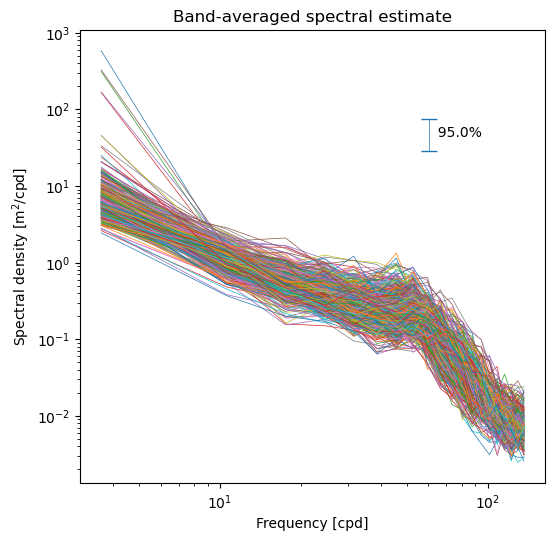

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# estimate 1
# L=12*24*11 # number of datapoints to include in each spectral estimate (5-min samples)
# M = 11 # number of bands to average
# estimate 2
# L=12*24*31 # number of datapoints to include in each spectral estimate (5-min samples)
# M = 14 # number of bands to average
# estimate 3
# L=12*24*21 # number of datapoints to include in each spectral estimate (5-min samples)
# M = 17 # number of bands to average
#
L=12*24*5 # number of datapoints to include in each spectral estimate (5-min samples)
M = 35 # number of bands to average
#
YY=[]
YY_time=[]
ind = np.arange(0,len(zeta.values)-L,12*24)
for n in np.arange(0,len(ind)-1):
    yy = zeta[ind[n]:ind[n]+L].values
    if n==0:
        # tt.spectrum_band_avg(yy,dt,M,winstr=None,plotflag=True,ebarflag=True)
        YY_avg, freq, EDOF = tt.spectrum_band_avg(yy,dt,M,winstr=winstr,plotflag=True,ebarflag=True)
        YY = np.reshape(YY_avg,(YY_avg.size,1))
    else:
        # tt.spectrum_band_avg(yy,dt,M,winstr=None,plotflag=True,ebarflag=False)
        YY_avg, freq, EDOF = tt.spectrum_band_avg(yy,dt,M,winstr=winstr,plotflag=True,ebarflag=False)
        YY=np.append(YY,np.reshape(YY_avg,(YY_avg.size,1)),axis=1)        

YY_time= np.arange(0,len(ind)-1)
        
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('Spectral density [m$^2$/cpd]')

In [23]:
# f = gsw.geostrophy.f(np.abs(ds.LATITUDE.values[0]))
# inertial_period = 2*np.pi/f/3600
# print('Latitude is '+ f'{ds.LATITUDE.values[0]:.1f}')
# print('Inertial period is '+ f'{inertial_period:.1f}' + ' hours')
# f_cpd=f*3600*24/(2*np.pi)
# M2_cpd=24/12.42

Text(0.5, 0, 'time (d)')

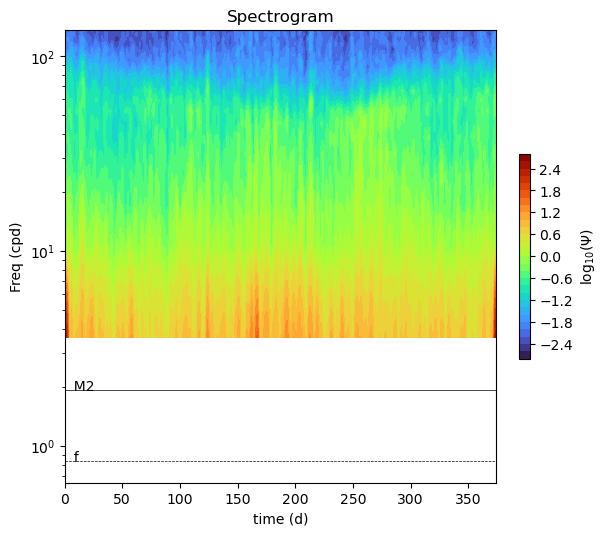

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cs = plt.contourf(YY_time, freq, np.log10(YY), 30, cmap=plt.cm.turbo)
plt.semilogy()
plt.semilogy(YY_time,0.*YY_time+f_cpd,'k--')
plt.semilogy(YY_time,0.*YY_time+M2_cpd,'k-')
plt.text(YY_time[0],f_cpd,'  f',horizontalalignment='left')
plt.text(YY_time[0],M2_cpd,'  M2',horizontalalignment='left')
cb = plt.colorbar(cs,fraction = 0.022)
cb.set_label('log$_{10}$($\Psi$)',fontsize = 10)
    
plt.title('Spectrogram')
plt.ylabel('Freq (cpd)')
plt.xlabel('time (d)')

Roger said:

Something that puzzles me about these displacement spectra is the big near-inertial energy.  I thought those motions were supposed to be horizontal.  Maybe horizontal gradients getting pushed around?

Tom:
- Interesting question.  I don't see a clear inertial peak in the plot above.
- I adjusted the analysis parameters to better resolve low frequenices.  I think it clarifies what's happening in the near-inertial band significantly.  That may have been just leakage we were seeing before.

Roger:
- I agree about the leakage.  I had thought that there was an inertial peak in the first band-averaged spectral plot above but I have added lines at f and M2 and my "inertial" peak does not line up with f.

Text(0.5, 0, 'time (d)')

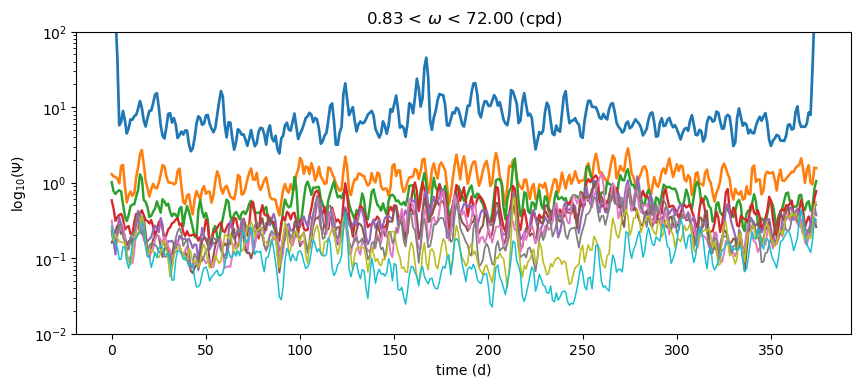

In [25]:
fig = plt.figure(figsize=(10,4))
ax_ts = fig.add_subplot(111)
# print(np.shape(YY_time))
# print(np.shape(np.transpose(YY)))
(nt,nfreq)=np.shape(np.transpose(YY))
freq_l=f_cpd
freq_h=72  # 3 cph
# freq_h=24  # 1 cph
for jfreq in range(len(freq)):
    if freq_l < freq[jfreq] < freq_h:
        lw=2-(freq[jfreq]-freq_l)/(freq_h-freq_l)
        plt.semilogy(YY_time,np.transpose(YY[jfreq,:]),linewidth=lw)
ax_ts.set_ylim([10**-2,10**2])
plt.title('{:.2f} < $\omega$ < {:.2f} (cpd)'.format(freq_l,freq_h))
plt.ylabel('log$_{10}$($\Psi$)')
plt.xlabel('time (d)')
# print(freq_l,freq_h)

Text(0.5, 0, 'time (d)')

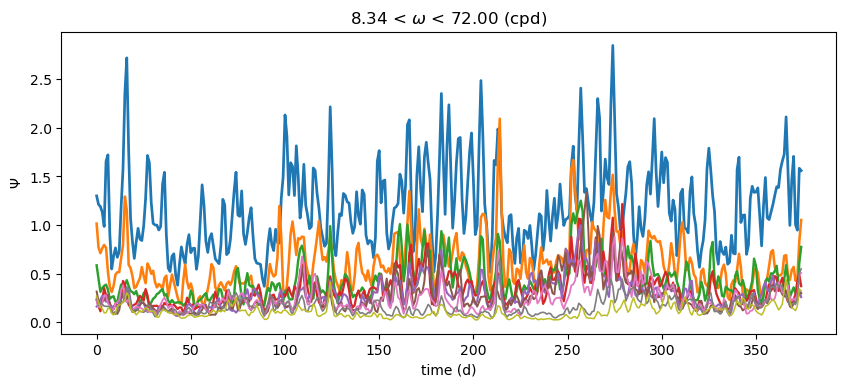

In [26]:
fig = plt.figure(figsize=(10,4))
ax_ts = fig.add_subplot(111)
# print(np.shape(YY_time))
# print(np.shape(np.transpose(YY)))
(nt,nfreq)=np.shape(np.transpose(YY))
freq_l=10*f_cpd
freq_h=72  # 3 cph
# freq_h=24  # 1 cph
for jfreq in range(len(freq)):
    if freq_l < freq[jfreq] < freq_h:
        lw=2-(freq[jfreq]-freq_l)/(freq_h-freq_l)
        plt.plot(YY_time,np.transpose(YY[jfreq,:]),linewidth=lw)
# ax_ts.set_ylim([10**-1,10**2])
plt.title('{:.2f} < $\omega$ < {:.2f} (cpd)'.format(freq_l,freq_h))
plt.ylabel('$\Psi$')
plt.xlabel('time (d)')
# print(freq_l,freq_h)

Text(0.5, 0, 'time (d)')

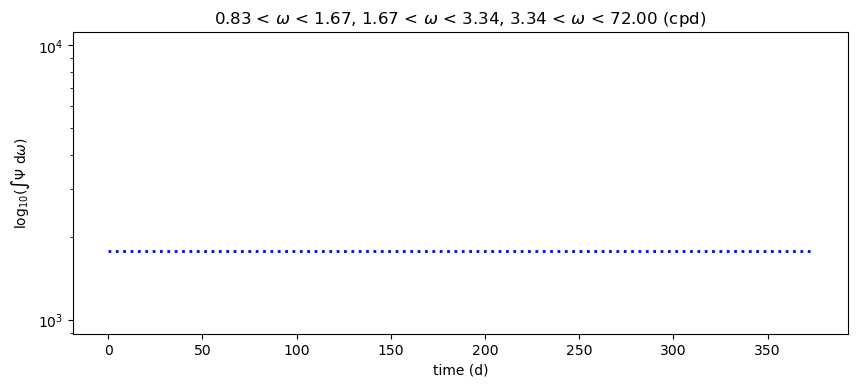

In [27]:
fig = plt.figure(figsize=(10,4))
ax_ts = fig.add_subplot(111)
# print(np.shape(YY_time))
# print(np.shape(np.transpose(YY)))
(nt,nfreq)=np.shape(np.transpose(YY))
freq_l=f_cpd
freq_h=72  # 3 cph
# freq_h=24  # 1 cph
freq_a=2.*freq_l
freq_b=2.*freq_a
# freq_a=freq_l+(freq_h-freq_l)/3
# freq_b=freq_l+2*(freq_h-freq_l)/3
YY_varb3=np.zeros((3,nt))
for jfreq in range(len(freq)):
    if freq_l < freq[jfreq] < freq_a:
        YY_varb3[0,:]=YY_varb3[0,:]+YY[jfreq,:]*0.5*(freq[jfreq+1]-freq[jfreq-1])
    elif freq_a < freq[jfreq] < freq_b:
        YY_varb3[1,:]=YY_varb3[1,:]+YY[jfreq,:]*0.5*(freq[jfreq+1]-freq[jfreq-1])
    elif freq_b < freq[jfreq] < freq_h:
        YY_varb3[2,:]=YY_varb3[2,:]+YY[jfreq,:]*0.5*(freq[jfreq+1]-freq[jfreq-1])
# compute means and standard deviations
YY_mn3=np.mean(YY_varb3,axis=1)
YY_sd3=np.std(YY_varb3,axis=1)
line_color=['r','g','b']
for jfreq in range(3):
    lw=1+0.5*jfreq
    plt.semilogy(YY_time,np.transpose(YY_varb3[jfreq,:]),line_color[jfreq],linewidth=lw)
    plt.semilogy(YY_time,YY_mn3[jfreq]*np.ones(nt),'--'+line_color[jfreq],linewidth=lw)
    plt.semilogy(YY_time,(YY_mn3[jfreq]+YY_sd3[jfreq])*np.ones(nt),':'+line_color[jfreq],linewidth=lw)
    plt.semilogy(YY_time,(YY_mn3[jfreq]-YY_sd3[jfreq])*np.ones(nt),':'+line_color[jfreq],linewidth=lw)
# ax_ts.set_ylim([10**-1,10**2])
plt.title(f'{freq_l:.2f} < $\omega$ < {freq_a:.2f},'
         +f' {freq_a:.2f} < $\omega$ < {freq_b:.2f},' 
         +f' {freq_b:.2f} < $\omega$ < {freq_h:.2f} (cpd)')
#plt.title('{:.2f} < $\omega$ < {:.2f}'.format(freq_l,freq_h))
plt.ylabel('log$_{10}$($\int\Psi$ d$\omega$)')
plt.xlabel('time (d)')
# print(freq_l,freq_h)

Text(0.5, 1.0, '0.83 < $\\omega$ < 72.00 (cpd)')

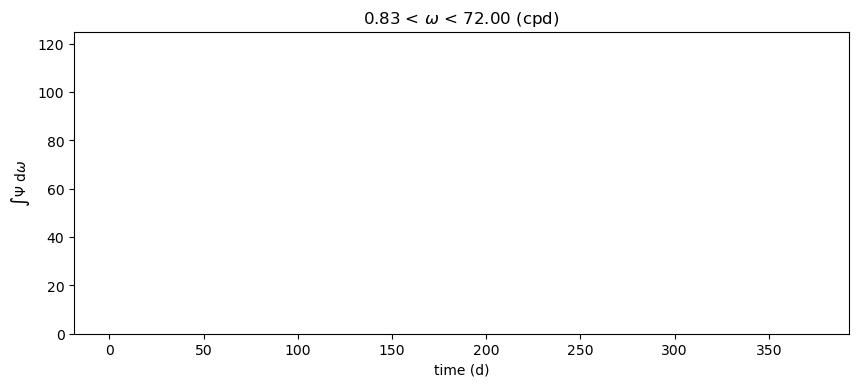

In [28]:
fig = plt.figure(figsize=(10,4))
ax_ts = fig.add_subplot(111)
freq_l=f_cpd
freq_h=72  # 3 cph
# freq_h=24  # 1 cph
YY_varb1=np.zeros((1,nt))
for jfreq in range(len(freq)):
    if freq_l < freq[jfreq] < freq_h:
        YY_varb1[0,:]=YY_varb1[0,:]+YY[jfreq,:]*0.5*(freq[jfreq+1]-freq[jfreq-1])
YY_mn1=np.mean(YY_varb1,axis=1)
YY_sd1=np.std(YY_varb1,axis=1)
line_color=['b']
# plt.semilogy(YY_time,np.transpose(YY_varb1[0,:]),linewidth=lw)
# plt.ylabel('log$_{10}$($\int\Psi$ d$\omega$)')
# ax_ts.set_ylim([10**1,2*10**2])
plt.plot(YY_time,np.transpose(YY_varb1[0,:]),linewidth=lw)
plt.plot(YY_time,YY_mn1[0]*np.ones(nt),'--'+line_color[0],linewidth=lw)
plt.plot(YY_time,(YY_mn1[0]+YY_sd1[0])*np.ones(nt),':'+line_color[0],linewidth=lw)
plt.plot(YY_time,(YY_mn1[0]-YY_sd1[0])*np.ones(nt),':'+line_color[0],linewidth=lw)
plt.ylabel('$\int\Psi$ d$\omega$')
ax_ts.set_ylim([0,125])
plt.xlabel('time (d)')
plt.title(f'{freq_l:.2f} < $\omega$ < {freq_h:.2f} (cpd)')

In [29]:
print(["{:.2f}".format(x) for x in YY_mn3])
print(["{:.2f}".format(x) for x in YY_sd3])
print(["{:.2f}".format(x) for x in YY_mn1])
print(["{:.2f}".format(x) for x in YY_sd1])

['0.00', '0.00', '-706.07']
['0.00', '0.00', '2483.15']
['-706.07']
['2483.15']


In [30]:
ratio3=YY_sd3/YY_mn3
ratio1=YY_sd1/YY_mn1
print(["{:.2f}".format(x) for x in ratio3])
print(["{:.2f}".format(x) for x in ratio1])

['nan', 'nan', '-3.52']
['-3.52']


C:\Users\jtomf\AppData\Local\Temp/ipykernel_7040/2699784629.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratio3=YY_sd3/YY_mn3


180 m: <br>
L=12x24x41, M=11: ratio3=[0.42,0.34,0.22], ratio1[0.18] <br>
L=12x24x31, M=14: ratio3=[0.46,0.41,0.23], ratio1[0.19] <br>
L=12x24x21, M=17: ratio3=[0.59,0.43,0.24], ratio1[0.20] <br>

150 m: <br>
L=12x24x41, M=11: ratio3=[0.58,0.34,0.24], ratio1[0.19] <br>
L=12x24x31, M=14: ratio3=[0.59,0.42,0.24], ratio1[0.21] <br>
L=12x24x21, M=17: ratio3=[0.74,0.44,0.25], ratio1[0.23] <br>

120 m: <br>
L=12x24x41, M=11: ratio3=[0.42,0.31,0.21], ratio1[0.24] <br>
L=12x24x31, M=14: ratio3=[0.47,0.38,0.32], ratio1[0.25] <br>
L=12x24x21, M=17: ratio3=[0.50,0.44,0.34], ratio1[0.27] <br>

Extrapolating linearly to L=12x24x0 gives the "instantaneous intermittency" 0.22 < ratio1 < 0.30...? <br>
This is not much different from the computed values, prior to extrapolation. <br>
That is, the fluctuation timescale seems relatively well resolved already by the 21-41 day window range.

There seems also to be a systematic increase in intermittency toward the surface.